In [2]:
import os, sys
current = os.path.dirname(os.path.realpath('__file__'))
parent = os.path.dirname(current)
sys.path.append(parent)

import math
import copy
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter

from helpers import *  

### Question 1a

In [3]:
def compute_degrees(digraph):
    """Takes a directed graph and computes the (in+out) degrees for the nodes in the graph. 
    Returns a dictionary with the same set of keys (nodes) and their (in+out) degrees."""

    # Initialize degree dictionary with all out-degrees
    degrees = {k: len(v) for k, v in digraph.items()}
    # Add in-degrees for each incoming edge
    for v in digraph:
        for w in digraph[v]:
            degrees[w] += 1
    return degrees

def compute_neighbourhoods(digraph):
    """Takes a directed graph and computes the neighbourhood for the nodes in the graph. 
    Returns a dictionary with the same set of keys (nodes) and their neighbourhoods."""
    
    # Initialize neighbourhood dictionary with all out-neighbours
    neighbourhoods = copy.deepcopy(digraph)
    # Add in-neighbours of each incoming edge
    for v in digraph:
        for w in digraph[v]:
            neighbourhoods[w].add(v)
    return neighbourhoods

def compute_local_clustering_coefficients(digraph, neighbourhoods, rounding=True):
    """Takes a directed graph and computes the clustering coefficient for the nodes in the graph. 
    Returns a dictionary with the same set of keys (nodes) and their clustering coefficient."""
    clustering_coefficients = {k: 0 for k in digraph.keys()}

    for v in tqdm(digraph):

        numerator = 0
        for j in neighbourhoods[v]:
            for k in digraph[j]:
                if k in neighbourhoods[v]:
                    numerator += 1

        denominator = len(neighbourhoods[v])*(len(neighbourhoods[v])-1)

        if denominator == 0: clustering_coefficients[v] = 0  # Divide by 0 error when v has 0 or 1 neighbours
        elif numerator/denominator > 1: clustering_coefficients[v] = 1  # Self referential citations can cause numerator > denominator
        elif rounding is True: clustering_coefficients[v] = round(numerator/denominator, 2)
        else: clustering_coefficients[v] = numerator/denominator

    return clustering_coefficients

100%|██████████| 27770/27770 [00:03<00:00, 7105.61it/s]


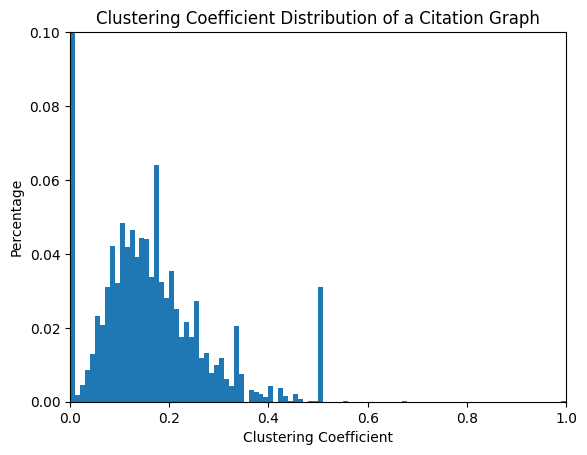

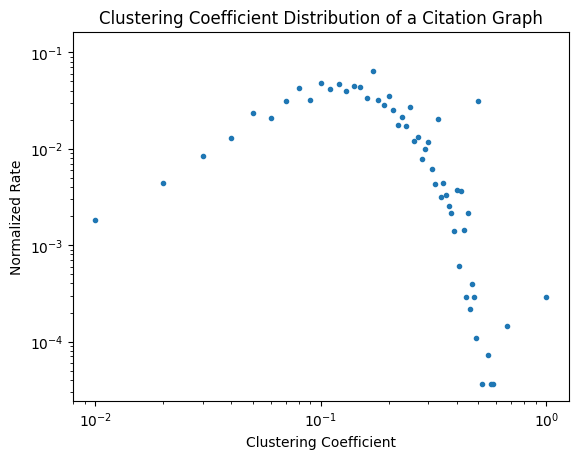

100%|██████████| 27770/27770 [00:02<00:00, 11982.86it/s]


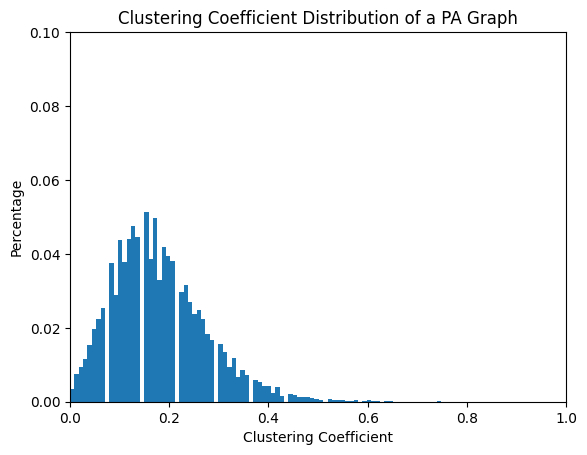

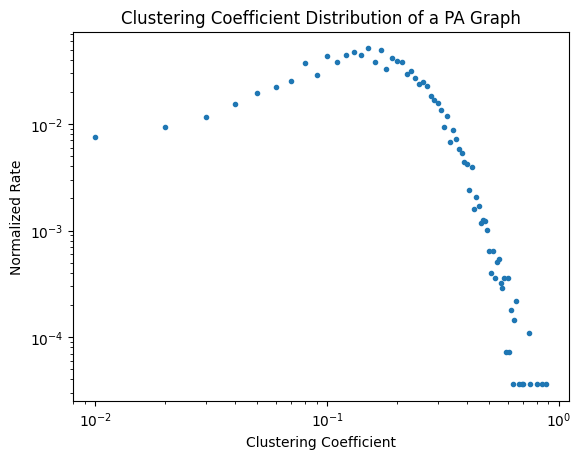

In [65]:
citation_graph = load_graph(parent + "/networks/alg_phys-cite.txt")
neighbourhoods = compute_neighbourhoods(citation_graph)
clustering_coefficients = compute_local_clustering_coefficients(citation_graph, neighbourhoods)
clustering_coefficients_distribution = Counter(clustering_coefficients.values())
normalised_clustering_coefficients_distribution = {k: v/len(citation_graph) for k,v in clustering_coefficients_distribution.items()}

plt.hist(clustering_coefficients.values(), bins=100, weights=np.ones(len(citation_graph))/len(citation_graph))
plt.title('Clustering Coefficient Distribution of a Citation Graph')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Percentage')
plt.xlim([0, 1])
plt.ylim([0, 0.1])
plt.show()

plt.title('Clustering Coefficient Distribution of a Citation Graph')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Normalized Rate')
plt.loglog(normalised_clustering_coefficients_distribution.keys(), normalised_clustering_coefficients_distribution.values(), marker='.', linestyle='None')
plt.show()

EX_GRAPH_PA1 = make_PA_Graph(27770, 13)
neighbourhoods = compute_neighbourhoods(EX_GRAPH_PA1)
clustering_coefficients = compute_local_clustering_coefficients(EX_GRAPH_PA1, neighbourhoods)
clustering_coefficients_distribution = Counter(clustering_coefficients.values())
normalised_clustering_coefficients_distribution = {k: v/len(EX_GRAPH_PA1) for k,v in clustering_coefficients_distribution.items()}

plt.hist(clustering_coefficients.values(), bins=100, weights=np.ones(len(EX_GRAPH_PA1))/len(EX_GRAPH_PA1))
plt.title('Clustering Coefficient Distribution of a PA Graph')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Percentage')
plt.xlim([0, 1])
plt.ylim([0, 0.1])
plt.show()

plt.title('Clustering Coefficient Distribution of a PA Graph')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Normalized Rate')
plt.loglog(normalised_clustering_coefficients_distribution.keys(), normalised_clustering_coefficients_distribution.values(), marker='.', linestyle='None')
plt.show()

### Question 1b

In [66]:
def get_in_degrees_logs(total_nodes, out_degree, selected_nodes):
    """Records the in-degrees w.r.t the number of nodes added
    for each selected node. Returned as a list of lists"""
    PA_graph = make_complete_graph(out_degree)
    trial = PATrial(out_degree)

    in_degrees_logs = [[] for _ in range(len(selected_nodes))]
    for vertex in tqdm(range(out_degree, total_nodes)):
        PA_graph[vertex] = trial.run_trial(out_degree)
        in_degrees = compute_in_degrees(PA_graph)

        for selected_node, log in zip(selected_nodes, in_degrees_logs):
            if vertex >= selected_node:  # Selected node has already been added
                log.append(in_degrees[selected_node])
            else:  # Selected node not yet been added to graph
                log.append(0)
        
    return in_degrees_logs

100%|██████████| 9980/9980 [03:11<00:00, 52.15it/s] 


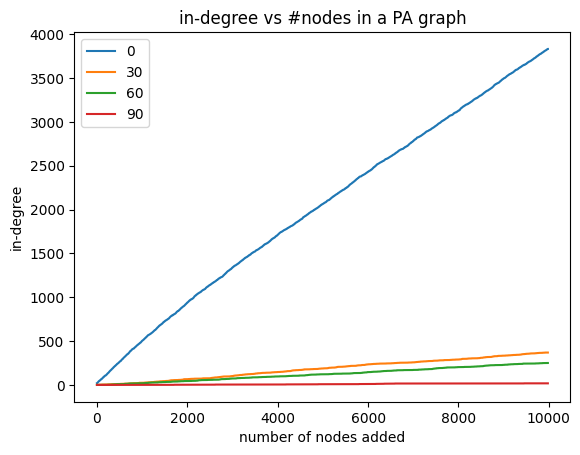

In [67]:
total_nodes, out_degree, selected_nodes = 10000, 20, [0, 30, 60, 90]
in_degrees_logs = get_in_degrees_logs(total_nodes, out_degree, selected_nodes)
plt.title("in-degree vs #nodes in a PA graph")
plt.xlabel("number of nodes added")
plt.ylabel("in-degree")
for i in range(len(in_degrees_logs)):
    plt.plot(range(len(in_degrees_logs[i])), in_degrees_logs[i], label=selected_nodes[i])
plt.legend()
plt.show()

### Question 1c

In [2]:
def make_C_Graph(n, m, p1, p2, p3, p4, selected_nodes=[]):
    """Construct a C graph as defined in the question"""
    C_graph = make_complete_graph(m)
    degrees_logs = [[] for _ in range(len(selected_nodes))]

    for vertex in tqdm(range(n-m)):
        degrees = compute_degrees(C_graph)

        # Add new node v joined to m existing nodes with probability proportional to their degree   
        if random.random() < p1:
            neighbours = random.choices(list(degrees.keys()), weights=degrees.values(), k=m)
            C_graph[vertex] = set(neighbours)

        # Add m random edges between existing nodes with endpoints proportional to their degree
        if random.random() < p2:
            new_edges_counter = 0
            total_counter = 0
            while new_edges_counter != m:  # If we naively choose edges we may choose some that already exist
                start_node, end_node = random.choices(list(degrees.keys()), weights=degrees.values(), k=2)
                total_counter += 1
                if end_node not in C_graph[start_node]: 
                    C_graph[start_node].add(end_node)
                    new_edges_counter += 1
                if total_counter > 10_000: # Prevents halting if no more edges left to add (clique)
                    break

        # Delete an existing node chosen uniformly at random
        if random.random() < p3:
            if not len(C_graph.keys()) == 2:  # Prevents removing the last two vertices
                del_node = random.choices(list(C_graph.keys()), weights=None, k=1)[0]
                del C_graph[del_node]  # Remove node and out-edges
                for v in C_graph.values(): v.discard(del_node)  # Remove in-edges

        # Delete m existing edges chosen uniformly at random
        if random.random() < p4:
            deleted_edges_counter = 0
            total_counter = 0
            while deleted_edges_counter != m:  # If we naively choose edges we may choose some that don't exist
                start_node, end_node = random.choices(list(C_graph.keys()), weights=None, k=2)
                total_counter += 1
                if end_node in C_graph[start_node]: 
                    C_graph[start_node].discard(end_node)
                    deleted_edges_counter += 1
                if total_counter > 10_000: # Prevents halting if no more edges to remove
                    break
        
        # Preferential attachment analysis
        degrees = compute_degrees(C_graph)
        if selected_nodes is not None:
            for selected_node, log in zip(selected_nodes, degrees_logs):
                if selected_node in C_graph.keys():  # Selected node has already been added
                    log.append(degrees[selected_node])
                else:  # Selected node not yet been added to graph
                    log.append(0)

    return C_graph, degrees_logs

In [ ]:
selected_nodes = [0, 30, 60, 90]
C_graph, degrees_logs = make_C_Graph(2000, 20, 0.7, 0.1, 0.1, 0.1, selected_nodes)
in_degrees = compute_in_degrees(C_graph)  
out_degrees = {k: len(v) for k, v in  C_graph.items()}

fig1, ax1 = plt.subplots()
for i in range(len(degrees_logs)):
    plt.plot(range(len(degrees_logs[i])), degrees_logs[i], label=selected_nodes[i])
ax1.set_title("degree vs #nodes in a C graph")
ax1.set_xlabel("number of nodes added")
ax1.set_ylabel("degree")
ax1.legend()
fig1.tight_layout()

fig2, ax2 = plt.subplots()
ax2.hist(in_degrees.values(), bins=100, alpha=0.5, label='In-Degree', weights=np.ones(len(C_graph))/len(C_graph))
ax2.hist(out_degrees.values(), bins=100, alpha=0.5, label='Out-Degree', weights=np.ones(len(C_graph))/len(C_graph))
ax2.set_title('In and Out Degree Distribution of a C Graph')
ax2.set_xlabel('In/Out Degree')
ax2.set_ylabel('Percentage')
ax2.legend()
fig2.tight_layout()

plt.show()

fig3, ax3 = plt.subplots()
vertex_count = []
edge_count = []
weights = []

# for weight in range(2, 11, 2):
for weight in range(5, 101, 5):

    # p1, p2, p3, p4 = weight*1/(weight+3), 1/(weight+3), 1/(weight+3), 1/(weight+3)
    p1, p2, p3, p4 = 0.5, weight*0.5/(weight+2), 0.5/(weight+2), 0.5/(weight+2)

    C_graph, _ = make_C_Graph(2000, 20, p1, p2, p3, p4)
    neighbourhoods = compute_neighbourhoods(C_graph)
    clustering_coefficients = compute_local_clustering_coefficients(C_graph, neighbourhoods, rounding=False)

    vertex_count.append(len(C_graph.keys()))
    edge_count.append(sum([len(v) for v in C_graph.values()]))
    weights.append(weight)

    ax3.hist(clustering_coefficients.values(), bins=100, alpha=0.5, label=weight, weights=np.ones(len(C_graph))/len(C_graph))
    ax3.set_title('Clustering Coefficient Distribution of a C Graph')
    ax3.set_xlabel('Clustering Coefficient')
    ax3.set_ylabel('Percentage')
    ax3.set_xlim([0, 1])
    ax3.legend()
    fig3.tight_layout()

fig4, ax4 = plt.subplots()
ax4.plot(weights, vertex_count)
ax4.set_title('C Graph Vertex Count')
ax4.set_xlabel('Probability Weighting')
ax4.set_ylabel('Vertex Count')
fig4.tight_layout()

fig5, ax5 = plt.subplots()
ax5.plot(weights, edge_count)
ax5.set_title('C Graph Edge Count')
ax5.set_xlabel('Probability Weighting')
ax5.set_ylabel('Edge Count')
fig5.tight_layout()

plt.show()